<a href="https://colab.research.google.com/github/datametal/LLMs-in-Production/blob/main/llama_3_transformer_pdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Custom Chatbot With PDF Documents
Peng Wang 05/04/2024 [Visit my blog](https://ai-journey.com/2024/05/build-rag-chatbot-using-pdf-documents-powered-by-huggingface-and-llamaindex/)

*Recommend running this notebook using GPU support*


Retrieval Augmented Generation (RAG) involves enhancing Large Language Models (LLMs) with additional information from custom external data sources. This approach improves the LLM's understanding by providing context from retrieved data or documents, enhancing its ability to respond to user queries with domain-specific knowledge.

1. **Retrieve**: User queries are used to fetch relevant context from an external knowledge source. The queries are embedded into a vector space along with the additional context, allowing for a similarity search. The top k closest data objects from the vector database are then returned.

2. **Augment**: The user query and retrieved additional context are combined into a prompt template.

3. **Generate**: The retrieval-augmented prompt is then input into the LLM for final processing.

In my experiment, I utilized PDF documents as the external knowledge source. Users can ask questions or make queries based on the context provided in these documents. I employed the HuggingFace model `sentence-transformers/multi-qa-MiniLM-L6-cos-v1` for vector embedding and the pre-trained LLM model `meta-llama/Llama-2-7b-chat-hf` for generating the final results.

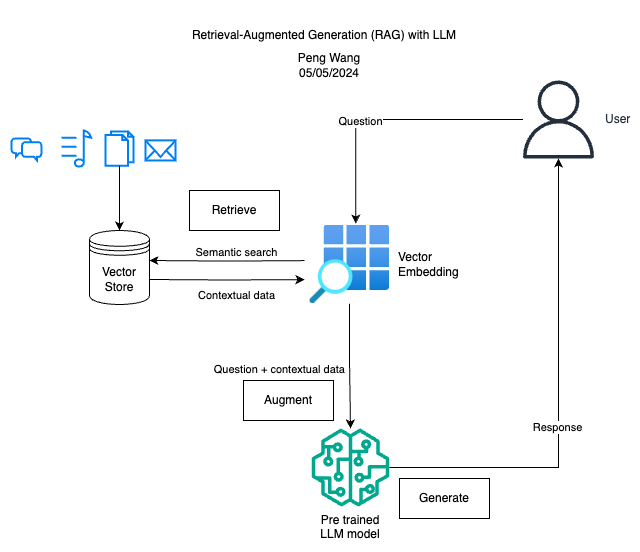

## Install Libraries

In [ ]:
!pip install -q pypdf
!pip install -q python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
!pip install -q transformers einops accelerate langchain bitsandbytes sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 20.0 MB/s eta 0:00:00


In [ ]:
!pip install -q llama-index
!pip install -q llama-index-llms-huggingface
!pip install -q llama-index-embeddings-langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 8.5 MB/s eta 0:00:00


In [ ]:
import os, logging, sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

Hugging Face Login

In [ ]:
from huggingface_hub import login

os.environ["HF_KEY"] = "Your Hugging Face access token goes here"
login(token=os.environ.get('HF_KEY'),add_to_git_credential=True)

Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Retrieve

**Load PDF Documents**

Upload PDF documents to the root directory. Example PDF documents

* [Innovate BC Innovator Skills Initiative](https://3044422.fs1.hubspotusercontent-na1.net/hubfs/3044422/ISI%20Program%20Guidelines%202023.pdf)
* [BC Arts Council Application Assistance](http://www.bcartscouncil.ca/app/uploads/sites/508/2022/05/FY2022-23-Application-Assistance-Guidelines-V3-1.pdf)

In [ ]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader(input_dir="/content/", required_exts=".pdf").load_data()
documents[0]

Document(id_='4b78908f-c3b7-4372-836f-95c48db31ba7', embedding=None, metadata={'page_label': '1', 'file_name': 'BC Arts Council Grants Guidelines 2023.pdf', 'file_path': '/content/BC Arts Council Grants Guidelines 2023.pdf', 'file_type': 'application/pdf', 'file_size': 148806, 'creation_date': '2024-05-12', 'last_modified_date': '2024-05-12'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='Application Assistance  Program Guidelines \nCurrent as of: May 18, 2022 \nThese guidelines are revised and updated with regularity.  Ensure you have the most current version of \nthese guidelines by checking the website at this link .  \n \nIntroduction  \nThe BC Arts Council welcomes applications from and funds projects by artists and arts and \ncultural practitione

**Vector Embedding**


[Local Embeddings with HuggingFace](https://docs.llamaindex.ai/en/stable/examples/embeddings/huggingface/)

HuggingFaceEmbeddings is a class in the LangChain library that provides a wrapper around Hugging Face's sentence transformer models for generating text embeddings. It allows you to use any sentence embedding model available on Hugging Face for tasks like semantic search, document clustering, and question answering.

Tried 3 HF sentence transformer models `multi-qa-MiniLM-L6-cos-v1,all-MiniLM-L6-v2, all-mpnet-base-v2`. `all-MiniLM-L6-v2` and `all-mpnet-base-v2` did not perform well and answers often have hallucination i.e. non factual incorrect answers. `multi-qa-MiniLM-L6-cos-v1` is more suitable for Q&A conversation.

In [ ]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

EMBEDDING_MODEL_NAME = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"

embed_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Initialize the Vector Store Index

Vector Store is a type of index that stores data as vector embeddings. These vector embeddings are numerical representations of the data that capture their semantic meaning. This allows for efficient similarity searches, where the most similar items to a given query are retrieved.

In [ ]:
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex.from_documents(documents, embed_model = embed_model)

## Augment

Set up prompts

In [ ]:
#from llama_index.core.prompts.prompts import PromptTemplate
from llama_index.core import PromptTemplate

system_prompt = """<|SYSTEM|># You are an AI-enabled admin assistant.
Your goal is to answer questions accurately using only the context provided.
"""

# This will wrap the default prompts that are internal to llama-index
query_wrapper_prompt = PromptTemplate("<|USER|>{query_str}<|ASSISTANT|>")

LLM_MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"

In [ ]:
import torch
from llama_index.llms.huggingface import HuggingFaceLLM

# To import models from HuggingFace directly
llm = HuggingFaceLLM(
    context_window=4096,
    max_new_tokens=512,
    generate_kwargs={"temperature": 0.1, "do_sample": False},
    system_prompt=system_prompt,
    query_wrapper_prompt=query_wrapper_prompt,
    tokenizer_name=LLM_MODEL_NAME,
    model_name=LLM_MODEL_NAME,
    device_map="auto",
    # uncomment this if using CUDA to reduce memory usage
    model_kwargs={"torch_dtype": torch.float16 , "load_in_8bit":True}
)

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

[Migrating from ServiceContext to Settings](https://docs.llamaindex.ai/en/stable/module_guides/supporting_modules/service_context_migration/)

Introduced in LlamaIndex v0.10.0, there is a new global Settings object intended to replace the old ServiceContext configuration.

The new Settings object is a global settings, with parameters that are lazily instantiated. Attributes like the LLM or embedding model are only loaded when they are actually required by an underlying module.

In [ ]:
from llama_index.core import Settings

Settings.embed_model = embed_model
Settings.llm = llm
Settings.chunk_size = 1024
#Settings.chunk_overlap = 256

## Generate

Initialize the Query Engine

In [ ]:
query_engine = index.as_query_engine(llm=llm, similarity_top_k=5)

Format the output with line wrapping enabled

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

Generate contextual results using retrieval-augmented prompt

In [ ]:
done = False
while not done:
  print("*"*30)
  question = input("Enter your question: ")
  response = query_engine.query(question)
  print(response)
  done = input("End the chat? (y/n): ") == "y"

******************************
Enter your question: what is BC arts Application Assistance program?
BC Arts Council Application Assistance program provides funding for individuals who are Deaf or have a disability to register for the online grant management system and create and submit grant applications, project updates, and final reports for BC Arts Council grant programs. The program also provides funding for support services such as editing, interpretation, translation, and reading guidelines. The maximum contribution for Application Assistance varies based on the type of support required, and individuals can request assistance by contacting the Accessibility Coordinator.
End the chat? (y/n): n
******************************
Enter your question: What costs could be covered by this grant
The BC Arts Council Grants Guidelines 2023 provide information on the types of costs that could be covered by the Application Assistance program. These costs include:

* Editing
* Interpretation
* T